In [ ]:
# This file is a implementation of the Recurrent Neural Network model 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
model = Sequential()
eurusd_train = pd.read_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\eurusd_train_normed.csv")
eurusd_test = pd.read_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\eurusd_test_normed.csv")
eurusd_train = eurusd_train.replace(np.nan, 0)
eurusd_test = eurusd_test.replace(np.nan, 0)


In [ ]:
# This take original data with trading features and then transforms the data in to a format which is
# able to be passed to the RNN model
# Chose the training size of the data
DATA_SIZE = 5000
train_original = eurusd_train.iloc[:DATA_SIZE,:].reset_index(drop=False) # eurusd_train.iloc[-DATA_SIZE:,:]
#test_original = eurusd_test.iloc[:DATA_SIZE,:]
TEST_SIZE = DATA_SIZE*2 + 30 
# using the next batch of the training data for validation
test_original = eurusd_train.iloc[DATA_SIZE + 30: TEST_SIZE,:].reset_index(drop=False)
features_to_use = ["spot_v_HF", "spot_v_MF", "spot_v_LF", "HF_ema_diff", 
                   "MF_ema_diff","LF_ema_diff", "LDN", "NY", "Asia", "target"]

#### Create Tensor Data Shape ######################################
# Data needs to be reshaped into 3D tensor
train_sample = train_original[features_to_use].values
test_sample = test_original[features_to_use].values

# this creates your dataset with the lookback periods it needs to use.

import numpy as np
# this lookback over a set period as the memory for the LSTM
look_back = 60
def create_dataset(dataset, populate_target ,look_back=look_back):
  dataX, dataY, target_dates = [], [], []
  for i in range(len(dataset)-look_back+1):
      # this takes the very last col as the target
    a = dataset[i:(i+look_back), :-1]
    dataX.append(a)
    # this code assumes that the target vector is the very last col.
    dataY.append(dataset[i + look_back - 1, -1])
    if populate_target:
        target_dates.append(test_original['Date'].loc[i + look_back - 1])
  return np.array(dataX), np.array(dataY), target_dates

# Implement the data transform on the training and train target data 
train_sample_transformed = create_dataset(train_sample,False, look_back)
train_data = train_sample_transformed[0]
train_target = train_sample_transformed[1]
# Implement the data transform on the training and train target data
test_sample_transformed = create_dataset(test_sample, True, look_back)
test_data = test_sample_transformed[0]
test_target = test_sample_transformed[1]
target_dates = test_sample_transformed[2]

# reshape the data which adds another list around every observation
train_data = train_data.reshape(train_data.shape[0], look_back, train_data.shape[2])
train_target = train_target.reshape(train_target.shape[0], 1)

test_data = test_data.reshape(test_data.shape[0], look_back, test_data.shape[2])
test_target = test_target.reshape(test_target.shape[0], 1)

print(test_results['logret'])

In [ ]:
'''
This code will create the LSTM model using the Keras package
The layers and model architecture are created such that we have 4 hidden LSTM nodes which feed a one neuron node for output 
using SOFTMAX activation
'''
# TODO: Functionise the belwo code such that we can iterate over various different model architectures.
# need to try understand the input shapes and what is required of it.
# look at tutorials where they use this data
# Friday: GOAL have the LSTM working with your input (and variable data set)
# BONUS GOAL: simulate trendy and mean reverty data.
# batch_input_shape (no_obversations,timelookback, features)
# set batch size (this is how often the weights will update
# from keras moodule
# keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', 
# recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
# recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
# recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
# recurrent_dropout=0.0, implementation=1, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)
BATCH_SIZE = 300
no_features = train_data.shape[2]
model = Sequential()
model.add(LSTM(4,batch_input_shape = (None,look_back,no_features), return_sequences = True))
model.add(LSTM(1, return_sequences = False, activation="softmax"))
#model.add(Dense(2, activation= "softmax"))
model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
model.summary()

In [33]:
# model training
'''
history = model.fit(x_train,y_train, epochs=100,validation_data=(x_test,y_test))
results = model.predict(x_test)
'''
 # train the lSTM model
history = model.fit(train_data,train_target,epochs = 300,validation_data=(test_data,test_target), verbose=0)

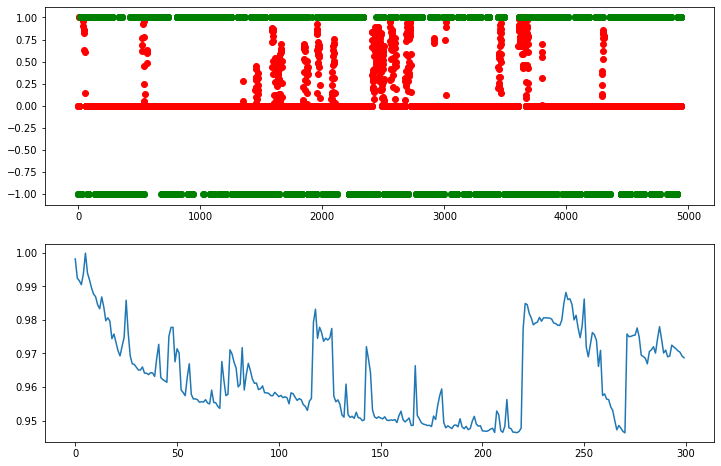

In [35]:
# plot the predicted result (red ) vs the actual output.
# Here the red at 0 implies 0% probability of being a buy.
import matplotlib.pyplot as plt
results = model.predict(test_data)
fig , ax = plt.subplots(2,1,figsize=(12,8))
ax[0].scatter(range(len(results)), results, c = "r")
ax[0].scatter(range(len(test_target)), test_target, c = "g")
# lets see the history of the error update.
# want a smooth learning line
ax[1].plot(history.history['loss'])
plt.show()

array([[-3.77077251, -3.62112174, -2.03388392, -4.85746873, -2.01641818,
         0.33070086],
       [-4.09020146, -3.69558669, -2.07626712, -4.83655507, -2.02458851,
         0.32852463],
       [-4.60197656, -3.81557922, -2.1431084 , -4.86914407, -2.03328911,
         0.32627671],
       ...,
       [-0.80929306,  0.09202221, -0.31229262, -0.47708991, -0.71461784,
        -1.06383853],
       [-0.75726148,  0.09778996, -0.30904073, -0.46443473, -0.71445716,
        -1.06284846],
       [-0.68397369,  0.10862184, -0.30307008, -0.4479426 , -0.71424005,
        -1.06185307]])

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
def signal(x, thold):
    '''
    :param x: 
    :return: signal to trade 
    '''
    if x >= thold:
        return 1
    elif x <= (1-thold):
        return -1
    else:
        return 0
predicted = [signal(i, 0.55) for i in results]

true_class = [np.sign(i[0]) for i in test_target]
print(accuracy_score(true_class, predicted))

print(pd.DataFrame(
    confusion_matrix(true_class, predicted),
    columns=['Predicted Buy',"shithouse",'Predicted Sell'],
    index=['True Buy',"shithouse",'True Sell']
))
# To do --> Create a relatively realistic backtester (probably needs to be a .py file engine)
# Run the model on the real data (explore running on a server. tie a small subset of data to see how long it might actually take?
# test model on test data and see if returns work.
# create a timeseries that generates a trendy or non trendy price series on same frequency as the hourly eurusd data.
# test the model to see if it can pick this up. 
# potential GM questions, LSTM architecture? Best practises around standardisation? Are you implementing the notes and points reaised by the
# examiners?
# Ultimate GOAL: create a trend baseded model which can actually pick up price action and place bet sizes which are relatively intelligent.
# is there a way of testign some neuro fuzzy logic perhaps?
# Probabitily distribution of outcomes for each trade based on the trend and external factors

0.5347095729609391
           Predicted Buy  shithouse  Predicted Sell
True Buy            2432          8             108
shithouse              0          0               0
True Sell           2146         37             210


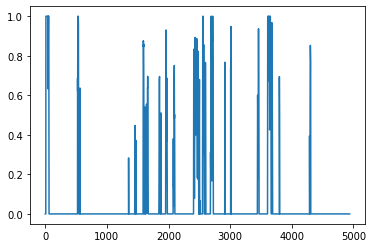

In [37]:
#single_sample = np.array([test_data[0]])
#print(model.predict(single_sample))
#print(results)
#print(eurusd_test.iloc[:200,:].head())
#test_original['Predictions'].shift(2)
plt.plot(results)

In [38]:
# Backtester_type_code to assess the model performance
# merging signals to the df
predictions = pd.DataFrame({"Date" : target_dates,"Predictions": predicted})
test_original = pd.merge(test_original,predictions,how="left", on="Date").fillna(0)

Index(['index', 'spot_v_HF', 'spot_v_MF', 'spot_v_LF', 'HF_ema_diff',
       'MF_ema_diff', 'LF_ema_diff', 'Date', 'CCY', 'logret', 'LDN', 'NY',
       'Asia', 'target', 'Predictions'],
      dtype='object')

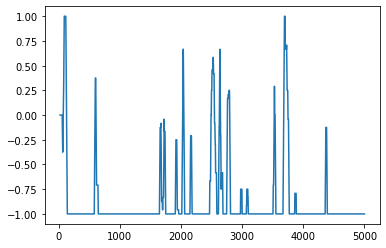

In [39]:
# Plot the scaled signal 
# SCALED SIGNAL works by cumulating all the predictions and placing them in a layered approach across the trading horizon.
# TODO: Allow the model freedom to test various trade horizons
trade_horizon = 24
test_original["scaled_signal"] = test_original['Predictions'].shift(2).rolling(trade_horizon).sum()/trade_horizon
# no shift needed as we have already done that in previous step
test_original['strat_returns'] = test_original['logret']*test_original['scaled_signal']
test_original['strat_returns_sum'] = test_original['strat_returns'].cumsum()
test_original["scaled_signal"].plot()
plt.show()

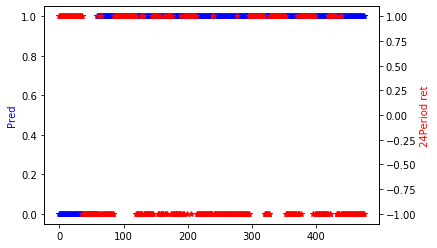

In [27]:
#print(test_original[['Date',"CCY","Predictions", "logret", "strat_returns"]].head(50)) # "strat_returns_sum", "logret"
# plotting the results of the output vs predicted
ax1 = plt.plot()
s1 = test_original['Predictions']
plt.plot(s1,'b*')
plt.ylabel('Pred',color='b')
ax2 = plt.gca().twinx()
s2 = test_original['target']
ax2.plot(s2, 'r*')
plt.ylabel('24Period ret', color='r')
plt.show()

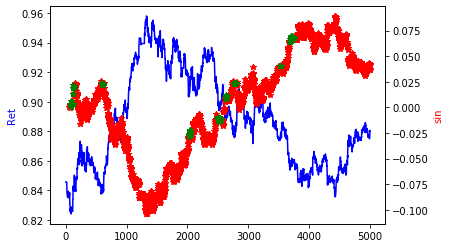

In [40]:
# plotting the buy (green) and sell (red) signals across the testing period alongside the currency move as well. 
ax1 = plt.plot()
s1 = test_original['CCY']
plt.plot(s1,'b')
plt.ylabel('CCY Spot Rate',color='b')

ax2 = plt.gca().twinx()
s2 = test_original['strat_returns_sum'].loc[test_original['scaled_signal'] <0 ]
ax2.plot(s2, 'r*')
plt.ylabel('Cumulative Returns', color='r')
s3 = test_original['strat_returns_sum'].loc[test_original['scaled_signal'] >0 ]
ax2.plot(s3, 'g*')
plt.show()

In [ ]:
test_original.to_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\signal_prediction_60_lookback_300pok_traindata.csv"
                     ,index = False)

In [ ]:
'''
#########################################################################################
                   Rough work on Dense NN model and other code variations
#########################################################################################
'''
from keras.models import Model # Dense
model.add(Dense(units=2, activation='relu', input_dim=2))
model.add(Dense(units=1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
x_train = np.array([[1,1],[1,0],[0,1],[0,0]])
y_train = np.array([0,1,0,0])
# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
model.fit(x_train, y_train, epochs=5, batch_size=32)

# set up the training data for the model
# we must normalise the inputs so they can pick up the correct values
data = [[[(i+j)/100]for i in range(0,5)] for j in range(0,200)]
target = [[(i+5)/100] for i in range(0,100)]
npData = np.array(data, dtype = float)
npTarget = np.array(target, dtype = float)
npData.shape
x_train, x_test, y_train, y_test = train_test_split(npData,npTarget,test_size = 0.2, random_state = 4)
# data stored as data[row_obversation][first_col_data][value_of_col]


# this code sets up the LSTM model.
'''
Original
model = Sequential()
model.add(LSTM((1),batch_input_shape = (None,5,1), return_sequences = True))
model.add(LSTM((1), return_sequences = False))
model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
model.summary()
'''
features_to_use = ["spot_v_HF", "spot_v_MF", "spot_v_LF", "HF_ema_diff",	"MF_ema_diff","LF_ema_diff"]
train_sample = eurusd_train[features_to_use].iloc[-DATA_SIZE:,:].values
#test_sample = eurusd_test.iloc[:200,features_to_use].values

In [ ]:
'''
This code acts as a test center for the code which will run on the cloud server.
All details on the server and CPU spce is available at the following
https://www.paperspace.com/
'''
# Test code for the cloud server.
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from trading_eng.ml_trading_module import create_train_test_file, create_dataset, get_accuracy, signal
import datetime
model = Sequential()
data_file = pd.read_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\eurusd_train_normed.csv") # pd.read_csv(r"/storage/eurusd_train_normed.csv")
#eurusd_test = eurusd_test.replace(np.nan, 0)
performance_store = {"data_size" : [], "Accuracy_Score" :[], "epochs": [] , "Info_Ratio" : [], "run_time" : []}
########################### Set Model Paramaters #############################
# this looks back over a set period as the memory for the LSTM
look_back = 66 # [21, 66]
trade_horizon = 24
model_features = ["spot_v_HF", "spot_v_MF", "spot_v_LF", "HF_ema_diff",
                   "MF_ema_diff","LF_ema_diff", "LDN", "NY", "Asia", "target"]
data_size = 250
test_split = 0.75
# the length of our prediction

# create data_set
train , test = create_train_test_file(data_file, data_size, test_split)
train_sample = train[model_features].values
test_sample = test[model_features].values
 # Parse the values into the LSTM format
train_data , train_target, null_dates = create_dataset(train_sample,False, look_back, test)
test_data, test_target, target_dates = create_dataset(test_sample, True, look_back, test)

# reshape seems to add another list around every observation
train_data = train_data.reshape(train_data.shape[0], look_back, train_data.shape[2])
train_target = train_target.reshape(train_target.shape[0], 1)
test_data = test_data.reshape(test_data.shape[0], look_back, test_data.shape[2])
test_target = test_target.reshape(test_target.shape[0], 1)

# Build up the model
BATCH_SIZE = 300
no_features = train_data.shape[2]
model = Sequential()
model.add(LSTM(4,batch_input_shape = (None,look_back,no_features), return_sequences = True))
model.add(LSTM(1, return_sequences = False, activation="softmax"))
model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])

EPOCH = 1
# train the model
# verbose = 1 gives the output of the training.
start_time = datetime.datetime.now()
lstm_engine = model.fit(train_data,train_target,epochs = EPOCH,validation_data=(test_data,test_target), verbose=1)
run_time = datetime.datetime.now() - start_time
# run training on the test data
results = model.predict(test_data)
# The % threshold needed to trigger a signal either way
thold = 0.55
predicted = [signal(i, thold) for i in results]
acc_score = get_accuracy(predicted, test_target)
predictions = pd.DataFrame({"Date" : target_dates,"Predictions": predicted})
test_results = pd.merge(test,predictions,how="left", on="Date").fillna(0)
# calculate the returns of the signal
test_results["scaled_signal"] = test_results['Predictions'].shift(2).rolling(trade_horizon).sum()/trade_horizon
# no shift needed as we have already done that in previous step
test_results['strat_returns'] = test_results['logret']*test_results['scaled_signal']
test_results['strat_returns_sum'] = test_results['strat_returns'].cumsum()
strat_return = test_results['strat_returns'].sum()
information_ratio = (test_results['strat_returns'].mean()*260)/(test_results['strat_returns'].std()*np.sqrt(260))

# Store the data as needed
performance_store['data_size'].append(data_size)
performance_store['epochs'].append(EPOCH)
performance_store['Accuracy_Score'].append(acc_score)
performance_store['Info_Ratio'].append(information_ratio)
performance_store['run_time'].append(run_time)
performance_df = pd.DataFrame(performance_store)
print(performance_df)